# AE1 - Working with Text

In this notebook we will be attempting to demonstrate the methods of natural-language processing, and apply said methods to the purposes of analyzing artists' lyrical content, and generating new lyrics.

Throughout this project, there will be 4 main 'coding' sections of importance:
    - Loading and Pre-processing Text
    - Text Analysis
    - Visualization
    - Generation

Additionally, we will reflect on the solutions and different methods of accomplishing these tasks at the end.


# 1. Loading and Pre-processing Text:
For the first part of the project, we will be pulling all the libraries for the project. We are placing all library imports in the same cell at the top of the notebook, so that anytime we need to test a new library or test functionality, we can run it separately from any processing code.

Note: This first import is retroactive, as a technique used in the project became deprecated after the project was completed. As I wish to preserve the coding that I did at the time instead of changing it, the deprecation warning is being ignored to maintain the original style of the notebook.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import nltk
import string
from lexicalrichness import LexicalRichness as lr
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter
from keyword import iskeyword
from nltk import ngrams
from nltk.corpus import stopwords
# If you are getting an error, run the commented code below
#nltk.download('stopwords')

Next, we will have to do very basic processing of the data, where we strip all text of any characters that may confuse search attempts or later word-processing (Such as uppercase, special characters, etc.)

In [3]:
spotify_df = pd.read_csv('spotify_millsongdata.csv')

# We are removing the link column, as it is unimportant for the purposes of our data
spotify_df = spotify_df.drop('link', axis=1)

# Replacing any potential nonsense values
spotify_df = spotify_df.replace([np.nan], 'none')

# Cleans punctuation out of all text
for series_name in spotify_df:
    spotify_df[series_name] = spotify_df[series_name].str.lower().replace('[^A-Za-z0-9 ]', '', regex=True)

# Used to convert all lyrics to list of words for word generation later
spotify_df['text'] = spotify_df['text'].str.split()

Next, we'll run a test, analyzing the most frequently appearing words throughout the entire lyric database. We will be doing this to see what will work well as stop-words for our language-processing.

In [4]:
d = {}
for idx in range(len(spotify_df['text'])):
    for word in spotify_df['text'][idx]:
        if word not in d:
            d[word] = 0
        d[word] += 1

sorted_d = sorted(d.items(), key=lambda x: x[1], reverse=True)

# Word frequency before stop words
print(sorted_d[0:30])

[('the', 497232), ('i', 426512), ('you', 425001), ('to', 296483), ('and', 294134), ('a', 255303), ('me', 201835), ('my', 170528), ('in', 167441), ('it', 149028), ('of', 139835), ('your', 119448), ('that', 114752), ('on', 113103), ('im', 106100), ('all', 98299), ('is', 93559), ('be', 93473), ('love', 92273), ('for', 90637), ('dont', 81339), ('but', 74471), ('so', 74355), ('we', 74017), ('its', 73648), ('know', 72388), ('just', 67152), ('with', 66698), ('like', 63448), ('no', 63361)]


Having seen from this result, we could eliminate words solely based on frequency, but that may skew the resulting words. This is because sometimes words with important significance to the song (such as 'love') occur more frequently than common stop-words (such as 'yeah'). 

In that case, it may be better to search for a curated list of stop-words for general natural-language processing use (as opposed to NLP for specialized fields). We can see nltk's 'stopwords' data at the top of the notebook.

With this, we can remove stopwords from the text to decrease the likelihood of getting a nonsensical response.

In [5]:
stop_words = list(stopwords.words('english'))
# Remove punctuation from stop word list
for word_idx in range(len(stop_words)):
    stop_words[word_idx] = re.sub('[^\w\s]', '', stop_words[word_idx])


for text_idx in range(len(spotify_df['text'])):
    spotify_df['text'][text_idx] = [w for w in spotify_df['text'][text_idx] if not w.lower() in stop_words]

# 2. Textual Analysis
# Progress Check:
So far we have:
- Completely processed the data
- Set up the means of counting word frequency and determining vocabulary richness

Next we will check word frequency and vocabulary richness (# of unique words) for each song:

The dataset at this point has:
    - Had all text lowercased, cleared of special characters (Note: Consider checking and replacing any NaN values or None values if found)
    - Had all lyrics turned into lists of words, with stop-words removed.
    
Our next goals will be to:
    - Start writing specific functions to modify the data. This will mean functions to display word frequency and vocabulary richness.

In [6]:
def ask_user():
    artist_1 = input('Who is the first artist you would like to see?\n')
    artist_1 = artist_1.lower()
    
    if bool(spotify_df.isin([artist_1]).any().any()) == False:
        print("We can't find that artist in our database."
                       " They may be missing, or the name may be misspelled." 
                       " Please restart the request and try again.")
        return ""
            
    artist_2 = input('Who is the second artist you would like to see?\n')
    artist_2 = artist_2.lower()
    
    if bool(spotify_df.isin([artist_2]).any().any()) == False:
        print("We can't find that artist in our database."
                       " They may be missing, or the name may be misspelled." 
                       " Please restart the request and try again.")
        return ""
    
    
    return [artist_1, artist_2]

artists = ask_user()

Who is the first artist you would like to see?
abba
Who is the second artist you would like to see?
pitbull


Next, we will take the names we were given by the user to create a dataframe with the initial information we will utilize for later visualizations.

In [7]:
def textual_analysis(artist_1, artist_2):
    artist_1_df = pd.DataFrame(columns=['song_title', 'word_frequency', 'vocabulary_richness', 'sentiment_analysis'])
    artist_2_df = pd.DataFrame(columns=['song_title', 'word_frequency', 'vocabulary_richness', 'sentiment_analysis'])
    
    # For artists with multiple songs, we'll have to separate by each song, and separately analyze each song.
    artist_1_IDs = spotify_df.loc[spotify_df['artist'] == artist_1].index.tolist()
    artist_2_IDs = spotify_df.loc[spotify_df['artist'] == artist_2].index.tolist()
    
    # Find data for first artist's songs
    for ID in artist_1_IDs:
        # Create initial dictionary for dataframe conversion
        ID_info = {}
        ID_info['song_title'] = spotify_df['song'][ID]
        # Creates word frequency dictionary from DataFrame methods
        ID_info['word_frequency'] = pd.Series(' '.join(spotify_df['text'][ID]).split()).value_counts().to_dict()
        # Use lexical richness library to find unique words, total words, and type/token ratio
        lex = lr(str(spotify_df["text"][ID]))
        ID_info['vocabulary_richness'] = {'Unique Words': lex.terms, 'Total Words':lex.words, 'TTR': lex.ttr}
        
        
        textblob = TextBlob(str(spotify_df["text"][ID]))
        ID_info['sentiment_analysis'] = ({"polarity": textblob.sentiment.polarity,
                                          "subjectivity":textblob.sentiment.subjectivity})
        
        ID_info = pd.DataFrame.from_dict(ID_info, orient='index')
        # Tranpose to allow dicts within DataFrames, for 
        # Word Frequency, Vocabulary Richness, and Sentiment Analysis preservation
        ID_info = ID_info.transpose()
        artist_1_df = pd.concat([artist_1_df, ID_info], ignore_index=True)
    
    # Same as above, for artist 2    
    for ID in artist_2_IDs:
            ID_info = {}
            ID_info['song_title'] = spotify_df['song'][ID]
            ID_info['word_frequency'] = pd.Series(' '.join(spotify_df['text'][ID]).split()).value_counts().to_dict()
            lex = lr(str(spotify_df["text"][ID]))
            ID_info['vocabulary_richness'] = {'Unique Words': lex.terms, 'Total Words':lex.words, 'TTR': lex.ttr}

            textblob = TextBlob(str(spotify_df["text"][ID]))
            ID_info['sentiment_analysis'] = ({"polarity": textblob.sentiment.polarity,
                                              "subjectivity":textblob.sentiment.subjectivity})

            ID_info = pd.DataFrame.from_dict(ID_info, orient='index')
            ID_info = ID_info.transpose()
            artist_2_df = pd.concat([artist_2_df, ID_info], ignore_index=True)
    
    # Common words between artists
    starting_dict_1 = Counter({})
    for dictionary in artist_1_df['word_frequency']:
        counted_dict = Counter(dictionary)
        starting_dict_1 += counted_dict
    starting_dict_2 = Counter({})
    for dicitonary in artist_2_df['word_frequency']:
        counted_dict = Counter(dictionary)
        starting_dict_2 += counted_dict
    
    artist_1_counts = starting_dict_1
    artist_2_counts = starting_dict_2
    common_df = pd.DataFrame(columns=['shared_word', 'artist_1_occurrences', 
                                      'artist_2_occurrences', 'total_occurrences'])
    
    # Find shared words by analyzing common words between both counts
    for key in artist_1_counts.keys():
        if key in artist_2_counts.keys():
            common_word = pd.DataFrame({'shared_word': key, 'artist_1_occurrences': 
                            artist_1_counts[key], 'artist_2_occurrences': artist_2_counts[key], 
                                       'total_occurrences': artist_1_counts[key] + artist_2_counts[key]}, index=[0])
            common_df = pd.concat([common_df, common_word], ignore_index=True)
    
    # Creates total counts for all words
    sum_counts = [x + y for x, y in zip(artist_1_counts.values(), artist_2_counts.values())]
    
    artists_counts = [dict(artist_1_counts), dict(artist_2_counts), sum_counts]
    artists_names = [artist_1, artist_2]
    return [artist_1_df, artist_2_df, artists_counts, common_df, artists_names]
    
artists_data = textual_analysis(artists[0], artists[1])

In [8]:
# To demonstrate that each element of the textual function works as intended:
print(artists_data[0]['song_title'][0])
print(artists_data[0]['word_frequency'][0])
print(artists_data[0]['vocabulary_richness'][0])
print(artists_data[0]['sentiment_analysis'][0])

ahes my kind of girl
{'could': 8, 'ever': 4, 'kind': 4, 'girl': 4, 'feel': 2, 'go': 2, 'leaves': 2, 'blue': 2, 'im': 2, 'without': 2, 'mine': 2, 'believe': 2, 'face': 2, 'fine': 2, 'look': 2, 'makes': 2, 'fellow': 1, 'things': 1, 'talking': 1, 'hours': 1, 'walking': 1, 'well': 1, 'hand': 1, 'squeezes': 1, 'holds': 1, 'park': 1, 'walk': 1, 'wonderful': 1, 'means': 1, 'something': 1, 'special': 1, 'way': 1, 'smiles': 1, 'sees': 1, 'lucky': 1, 'one': 1, 'plan': 1}
{'Unique Words': 37, 'Total Words': 65, 'TTR': 0.5692307692307692}
{'polarity': 0.4476190476190476, 'subjectivity': 0.654978354978355}


# Sources for Lexical Richness:
https://wordcruncher.com/pdf/Phrase%20Compare%20TTR%20Stat%20formulas.pdf
https://pypi.org/project/lexicalrichness

TTR, numerically, can be understand as how often words are repeated, on a scale of 0 to 1. A TTR value of 1 means no word is repeated. 
TTR is the ratio obtained by dividing the types (the total number of different words) occurring in a text or utterance by its tokens (the total number of words). A high TTR indicates a high degree of lexical variation while a low TTR indicates the opposite.

# 3. Time for Visualization !
Next we will focus on creating visualizations of the data we analyzed. We will be using everything we obtained in the textual analysis, which will benefit us in easing the requirements of these visualization functions.

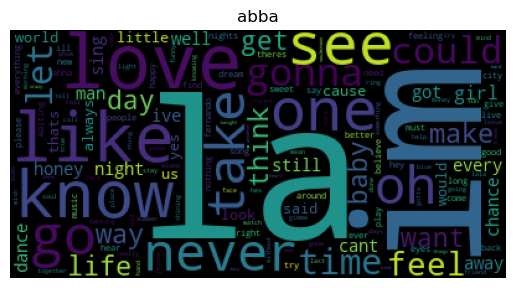

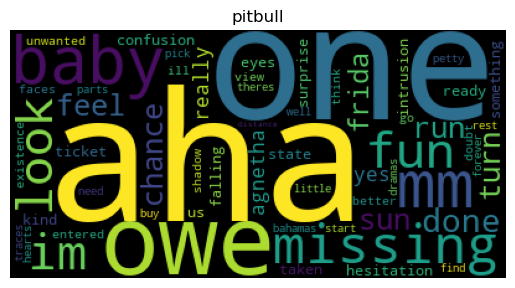

In [9]:
def word_cloud_visualization(artists_counts, artists=artists):
    
    artist_1_cloud = WordCloud().generate_from_frequencies(artists_counts[0])
    artist_2_cloud = WordCloud().generate_from_frequencies(artists_counts[1])
    plt.axis('off')
    
    plt.title(artists[0])
    plt.imshow(artist_1_cloud)
    plt.show()
    
    plt.axis('off')
    plt.title(artists[1])
    plt.imshow(artist_2_cloud)
    
    plt.show()
    
word_cloud_visualization(artists_data[2])

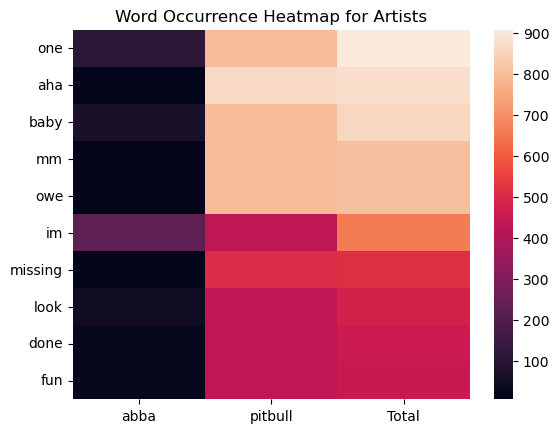

In [10]:
def heatmap(artists_counts, n = 10, artists=artists):
  
    artists_counts = artists_counts.sort_values('total_occurrences',ascending = False).head(n)
    artists_counts = artists_counts.set_index('shared_word').T
    # We convert the data to dictionaries and then to arrays to best capture data separately from labels
    data = artists_counts.to_dict()
    data = [np.array(list(d.values())) for d in data .values()]
     
    xlabels = [artists[0], artists[1], 'Total']

    sns.heatmap(data, xticklabels=xlabels, yticklabels=artists_counts.columns)
    plt.title('Word Occurrence Heatmap for Artists')
    plt.show()

heatmap(artists_data[3])

A massive difference in coloration can be explained by the difference in song # in artists. There will be a much bigger difference in color between artists of varying song # and size.

# 4. Generating Ngrams & Lyrics
Next, we will work on generating lyrics. We allow custom arguments so that users can specify N-gram input.

In [11]:
def generation(data, n=2, artists=artists):
    
    A1_ngrams_list = []
    A2_ngrams_list = []
    
    artist_1_IDs = spotify_df.loc[data['artist'] == artists[0]].index.tolist()
    artist_2_IDs = spotify_df.loc[data['artist'] == artists[1]].index.tolist()
    total_IDs = artist_1_IDs
    # All songs in which either artist appears
    for x in artist_2_IDs:
        total_IDs.append(x)
    # Creates N-grams for both artists    
    for idx in artist_1_IDs:
        text_ngram = ngrams(data['text'][idx], n)
        A1_ngrams_list.append(list(text_ngram))
    
    for idx in artist_2_IDs:
        text_ngram = ngrams(data['text'][idx], n)
        A2_ngrams_list.append(list(text_ngram))  
    
    # Start and end words of entire songs
    start_words = []
    end_words = []
    for ID in total_IDs:
        start_words.append(data['text'][ID][0])
        end_words.append(data['text'][ID][-1])
    # Dictionary for possible words based on first word appearing in N-gram
    possible_words = {}
    for n_gram_list in A1_ngrams_list:
        for ngram in n_gram_list:
            if ngram[0] not in possible_words:
                possible_words[ngram[0]] = [ngram[1]]
            else:
                possible_words[ngram[0]].append(ngram[1])
    for n_gram_list in A2_ngrams_list:
        for ngram in n_gram_list:
            if ngram[0] not in possible_words:
                possible_words[ngram[0]] = [ngram[1]]
            else:
                possible_words[ngram[0]].append(ngram[1])
    
    # Essentially a somewhat structured randomization to produce lyrics
    song = []
    sentence = ""
    curr_word = random.choice(start_words)
    while len(song) <= 12:
        sentence += " " + curr_word
        if curr_word in end_words:
            song.append(sentence)
            song[-1] = song[-1] + ','
            sentence = ""
            curr_word = random.choice(start_words)
            sentence += " " + curr_word
        curr_word = random.choice(possible_words[curr_word])
    return "\n".join(song);


lyrics = generation(spotify_df)

In [12]:
print(lyrics)

 im cool wanna move ive always see walks walk away,
 well military mind,
 well start must lovelight feel,
 im louie got little,
 im supposed la,
 nicola fasano hope meet,
 city im cryin,
 yeeeaaa pitbull 1st food go,
 working hard day,
 see honey honey honey look girl,
 love bet building im gonna find,
 people come back,
 wish merry christmas wish way,


# Final Application
In our final application, we will run all of the functions we have defined, and ask for user input to allow more in-depth feedback and customizability.

Who is the first artist you would like to see?
abba
Who is the second artist you would like to see?
the beatles


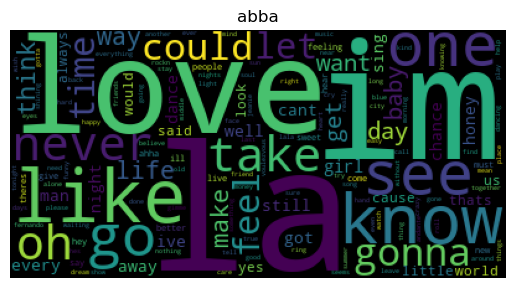

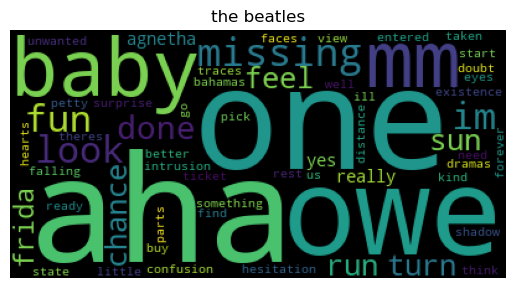

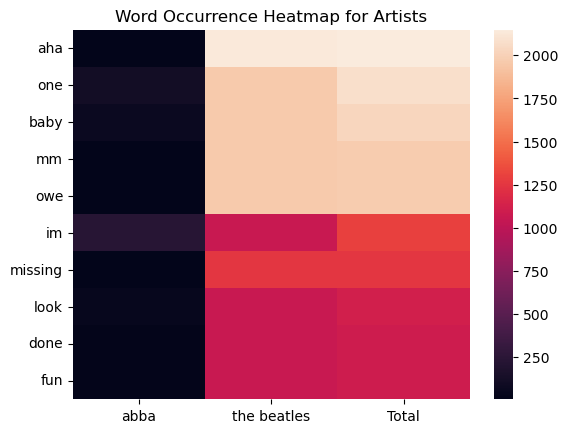

Specify N-gram size:
2
Song 1
 move im,
 passed great great laugh cry,
 cry cry,
 hey hey,
 suzy went married love,
 good norwegian wood,
 park summer rain like know,
 im tired wonder call,
 got every girl,
 know said,
 motorcars handlebars bicycles two ago story must sure got feeling,
 working like kids running home,
 girl another place ive learned game lover baby,

Song 2
 want,
 park summer night,
 summer night,
 getting better,
 smiles drift past become woman make cant sleep pretty cool decide take away,
 im outward bound life goes wanna kiss yeah,
 super trooper beams gonna make come day,
 wish dead nothing say goodbye,
 asked friends,
 good let,
 good see ooh,
 last free blackbird fly blackbird singing hari krishna man,
 everybody screamed kissed teacher till sun,


In [13]:
def final_application():
    artists_names = ask_user()
    
    if artists_names == "":
        print("Restart request...")
        return ""
    
    # Data used to make each subsequent visualization/generization
    data = textual_analysis(artists_names[0], artists_names[1])
    
    word_cloud_visualization(data[2], artists=artists_names)
    
    heatmap(data[3], artists=artists_names)
    
    user_input = (input("Specify N-gram size:\n"))
    if user_input.isdigit() == True:
        user_input = int(user_input)
    else:
        print("Invalid input. Defaulting as N = 2...")
        user_input = 2
    
    lyrics = generation(spotify_df, n=user_input, artists=artists_names)
    lyrics_2 = generation(spotify_df, n=user_input, artists=artists_names)
    print("Song 1")
    print(lyrics + '\n')
    print("Song 2")
    print(lyrics_2)
    
final_application()

# Reflection
In hindsight, one of the largest issues that came about in working on this application was that of the input size of the data. Having spent most previous experience in Data Science working on much smaller amounts of data, moving up to something larger (which is still likely much smaller than what you'd be expected to work on in the workforce) presented an issue as far as effciency. Any task that required iterating over the entire dataset would need to be as efficient as possible, to prevent a massive time delay between input and result. I believe that this was mostly solved in the application, as the bulk of longer code-return times occur before user input can be utilized (As in, most long waittimes on code compiling occurred during pre-processing, which would occur before the user would be able to access the data). Still, this meant more efficient code had to be produced during pre-processing to make the overall compilation as fast as possible. 

Another issue that was encountered during the project was the best means of containing large and diverse sets of data together. For instance, word frequencies were grouped either as dictionaries, or Counter objects. However, it would be cumbersome to return a dozen separate objects from one function, so the decision was made instead to fit dictionaries and objects inside of dataframes. This was additionally justified as the dataframe was going to be the end destination of the data, so it wouldn't be as important for the dataframe to be easily manipulatable as it could've been if a different method was used. 

In future iterations, it would likely be better to break the functions into even smaller chunks, and designate a system to keep track of every separate dataset. This would be so that the overall code could be more efficient, and that unneeded code wouldn't be run side-by-side with code of pertinence. That would be more beneficial as the input size grows larger, and the code entirely needs to become more efficient.
